# Reinforcement Learning: Q-Learning 
 >__Created__:  December 2020 Harrison B. Prosper<p>
 > Inspired by Manuel Amunategui's example at:<p> 
 https://amunategui.github.io/reinforcement-learning

     
## Introduction
In this tutorial we train an agent that can find an optimal path through a mountainous terrain by following a policy whose quality, quantified as an $expected$ reward, is defined by a function $Q$. The reinforcement learning algorithm that yields an estimate of the $Q$-function is called $Q$-learning. The environment, in this example, is represented by the triple $(x, y, z)$, where $(x, y)$ is the position in the terrain and $z(x, y)$ is the height of the terrain at the specified point. However, we also use the term environment in its usual, non-technical, sense.
     
## $Q$-Learning
Reinforcement learning is a class of algorithms for learning optimal strategies, that is, $(state, action)$ pairs, through trial and error guided by current and estimated future expected rewards. An *episode* (or history, or path) is a sequence of states, while an action moves the environment from one state to another. Optimal in the context of $Q$-learning means that the chosen episode, or path through state space, yields the maximum expected reward. This class of algorithms is particularly well suited for activities that can be construed as games with well-defined rules. Here we review the basics of the simplest $Q$-learning algorithm.
 

### Definitions
  1. __environment__: a configuration of objects. The objects could be, for example, pixels in an image.
  1. __state__: a set of attributes, $s$, that characterize the environment at a given time $t$. This could be, for example, the values of the pixels.
  1. __action__: a manipulation of the environment that causes it to transition to another state. Abstractly, an action, $a$, is the mapping $a: s \rightarrow s^\prime$, where $s$ is the current state and $s^\prime$ is the state to which the environment transitions. The mapping 
  can be modeled as a tuple: $(s, s^\prime)$.
  1. __reward__: the $immediate$ reward $R(s, a)$ associated with the action $a: s \rightarrow s^\prime$.
  1. __agent__: an automaton, e.g., a bot, that can take actions that cause the environment to transition from one state to another.
  1. __policy__: a method for choosing an action, $a$, in a given state, $s$. 
  1. __target state__: the desired state, $s^*$, to be reached by executing a sequence of actions determined by a policy.
  1. __Q-function__: the quality, or $expected$ reward, $Q(s, a)$ associated with action $a$ in state $s$. This is the function to be estimated by the training algorithm and the basis of the policy to be followed.
 
A transition from one state to another may depend on previous states. However, the Q-learning algorithm assumes the Markov property:  *the transition from one state to another depends only on the current state*. The following rule [1],  called the __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] ,
\end{align}

has been shown to converge [2] to a function $Q^*(s, a)$ that maximizes the expected reward from state $s$ to the target state, $s^*$. The quantities $$0 < \alpha \leq 1 \textrm{ and } 0 < \gamma < 1$$ are hyperparameters. The hyperparameter $\alpha$ determines how much of the future expected reward is to be taken into account during training relative to the current expected reward, while $\gamma$ is the amount by which a future expected reward is to be discounted relative to the immediate reward $R$.
     
Given that an action $a: s \rightarrow s^\prime$ maps an input state $s$ to an output state $s^\prime$, the update rule can be expressed entirely in terms of states as follows
     
\begin{align}
    Q(s, s^\prime) & = Q(s, s^\prime)  + \alpha [R(s, s^\prime) + \gamma \max_{s^{\prime\prime}}Q(s^\prime, s^{\prime\prime}) - Q(s, s^\prime)] .
\end{align}
Indeed, in this tutorial, the $Q$-function is a direct implementation of the map $a: s \rightarrow s^\prime \in S$, which is modeled as a Python map from state $s$ to its nearest neighbor states $S$, implemented as a list of states.
     
### References
  1. Christopher J.C.H Watkins, *Learning from delayed rewards*, PhD Thesis, University of Cambridge, England (1989).
  1. Christopher J.C.H. Watkins and Peter Dayan, *Technical Note $Q$-Learning*, Machine Learning, __8__, 279-292 (1992).

In [1]:
# standard modules
import os, sys, time
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import imageio as im

# draw graphs inline
%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

mp.rc('text', usetex=False)

### Class to model a landscape

In [3]:
class Landscape(dict):
    
    def __init__(self, filename):
        super(Landscape, self).__init__()
        
        if not os.path.exists(filename):
            raise FileNotFoundError(filename)
          
        # read landscape meshgrid data, which are stored as 
        # flattened meshgrids that need to be reshaped 
        # into 2D arrays
        df = pd.read_csv(filename)
       
        # reshape meshgrid into 2D arrays
        xx = df.x.to_numpy()
        yy = df.y.to_numpy()
        zz = df.h.to_numpy()
        zz = zz / np.max(zz)
                
        # ---------------------------------------------
        # create a grid of positions and a map of
        # positions to heights. 
        # ---------------------------------------------
        self.land_   = set()
        self.water_  = set()
        self.heights_= {}
 
        for x, y, z in zip(xx, yy, zz):
            
            pos = (int(x), int(y))
            
            self.__setitem__(pos, []) # self[pos] = z
            
            # divide points into those in water and those on land
            if z < 0:
                self.water_.add(pos)
            else:
                self.land_.add(pos)
                
            self.heights_[pos] = z

        # construct nearest neighbors of every position in grid   
        for pos in self:
            x, y = pos
            for ex, ey in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
                p = (x+ex, y+ey)
                if p in self:
                    self[pos].append(p)
        
        # cache 2D meshgrid
        n  = np.sqrt(len(xx)).astype(int)
        shape = (n, n)
        xx = xx.reshape(shape)
        yy = yy.reshape(shape)
        zz = zz.reshape(shape)
        self.terrain = xx, yy, zz
        
    def __del__(self):
        pass
        
    '''
    A string representation of dictionary.
    '''
    def __str__(self):
        
        positions = list(self.keys())
        positions.sort()
        
        s_str = ''
        for i, pos in enumerate(positions):
            nnpos = self.neighbors(pos)
            s_str += '%5d %s\th = %6.2f\t=> %s\n' % \
            (i+1, pos, self.heights_[pos], nnpos)

        return s_str[:-1]
    
    def neighbors(self, pos):
        if pos in self:
            return self[pos]
        else:
            raise ValueError('invalid position: %s' % pos)
            
    def heights(self):
        return self.heights_
    
    def positions(self):
        return set(self.keys())
    
    def land(self):
        return self.land_
    
    def water(self):
        return self.water_
    
    def meshgrid(self):
        return self.terrain

In [4]:
NAME = 'terrain2'
landscape = Landscape('../datasets/%s.csv.gz' % NAME)

### Plot landscape
Plot the landscape and mark the target destination.

In [5]:
def plot_landscape(landscape,
                   filename=None,
                   target=None,
                   paths=[]):
    
    xx, yy, zz = landscape.meshgrid()
    xmin, xmax = xx.min(), xx.max()
    ymin, ymax = yy.min(), yy.max()
    xlimits    = (xmin, xmax)
    ylimits    = (ymin, ymax)

    # set up an empty figure
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(1, 1, 1)
        
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    #ax.axis('off')
    
    # get a fancy color map
    mycmap = plt.get_cmap('gist_earth')
    plt.imshow(zz, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=mycmap)
    #plt.colorbar()
    
    # superimpose contours
    mylevels = np.arange(0, 1, 0.1)
    ax.contour(xx, yy, zz, cmap=mycmap, levels=mylevels)   

    if target != None:
        x, y = target
        ax.scatter([x],[y], s=100, c='red')
        
    if len(paths) > 0:
        kolors = ['white', 'cyan', 'red', 
                  'yellow', 'magenta']
        ii = 0
        for path in paths:
            # plot paths
            x = [z for z, _ in path]
            y = [z for _, z in path]
            ax.plot(x, y, c=kolors[ii], linewidth=2)
            ii += 1
            if ii >= len(kolors):
                ii = 0
                
    fig.tight_layout()
    
    if filename:
        print(filename)
        plt.savefig(filename)
        
    plt.show()

terrain2.png


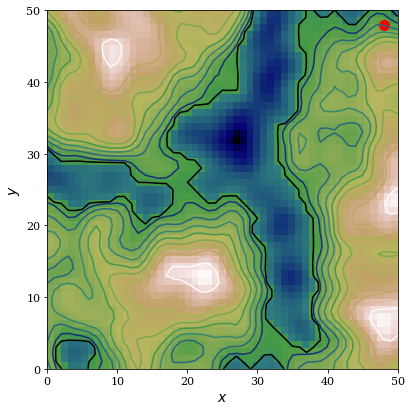

In [6]:
target_state = (48, 48)
plot_landscape(landscape, target=target_state, filename='%s.png' % NAME)

### Model environment
The states of the environment, itself modeled by the class *Environment*, are modeled as tuples $(x, y)$ with different values for the attributes $x$ and $y$. An action, $a$, is a mapping $a: (x, y) \rightarrow (x^\prime, y^\prime)$. The environment class has several methods, including *neighbors$(s)$* which returns, in a list, the nearest neighbor states connected to state $s$. Given the pair $(s, a)$, the environment returns the value of the immediate award $R(s, a)$ as well as the next state of the environment $s^\prime$. Since, in this example, $R(s, a)$ depends on $s^*$, the environment needs to be made aware of the desired target state $s^*$.

In this example, the immediate reward function is chosen to be

\begin{align}
R(s, a) & = \begin{cases}
                r^* &  \text{if } s^\prime = s^* \\
                r \, [h(s) - h(s^\prime)] & \text{otherwise}, 
            \end{cases}
\end{align}

where $h$ is the height of the terrain at any given position (that is, state), where the height of the highest peak is 1 unit. The factor $r$ sets the scale of the immediate reward, while $r^*$ is the reward for transitioning to the target state $s^*$. The above reward function penalizes transitions that involve climbing, are neutral about ones that maintain the height of the path, and favor transitions that decrease the height of the path.  

A possible issue with such a reward function is that it may cause the agent to get stuck in a high mountain valley. 

In [7]:
class Environment:
    '''
 Help on class Environment:

 class Environment
  |  Environment
  |
  |  Model an environment whose states are modeled by tuples (x, y),
  |  where x and y are non-negative integers.
  |
  |  Parameters
  |  ----------
  |  landscape     : a grid of points associated with heights
  |  rtarget       : target reward
  |  reward        : scale of reward
  |  penalty       : scale of penalty
    '''
    def __init__(self, landscape, rtarget=1, reward=1, penalty=-10):
        
        self.landscape = landscape
        self.rtarget   = rtarget # reward for transition to target state
        self.reward    = reward  # scale of immediate reward
        self.penalty   = penalty # scale of penalty to land in water
        self.heights   = landscape.heights() 
        
        self.target    = None  # target state
        self.state     = None  # current state
        
    def __del__(self):
        pass
    
    def __len__(self):
        return len(self.landscape)
      
    def positions(self):
        return self.landscape.positions()
    
    def land(self):
        return self.landscape.land()
    
    def water(self):
        return self.landscape.water()
    
    def neighbors(self, state):
        return self.landscape.neighbors(state)
    
    def current_state(self):
        return self.state
    
    def target_state(self):
        return self.target
           
    def target_reward(self):
        return self.rtarget
                        
    def set_target_state(self, target_state):
        self.target = target_state
    
    # implement action a: state => next_state
    def step(self, state, action):
        
        # make sure we have a valid (state, action) pair
        if state not in self.landscape:
            raise ValueError('invalid state: %s' % state)

        states = self.landscape.neighbors(state)

        if action <  0 or action >= len(states):
            raise ValueError('invalid action, %d, for state %s' % \
                             (d, state))
        
        # for now, assume a deterministic transition 
        # to next state. in future, we could implement
        # an epsilon transition policy:
        #   with probability 1-epsilon move to state 
        #   determined by action else move to a valid
        #   but randomly selected state
        next_state = states[action]
        
        # height of terrain at current location (state)
        h_state = self.heights[state]
            
        # height of terrain at next location (next_state)
        h_next_state = self.heights[next_state]
        
        # compute immediate reward

        done = False
        if next_state == self.target:
            reward = self.rtarget
            done   = True
            
        elif h_next_state < 0:
            # in water!
            reward = self.penalty * self.rtarget
            
        else:
            reward = self.reward * (h_state - h_next_state)
            
        self.state = next_state
        
        return (next_state, reward, done)

In [8]:
env = Environment(landscape, rtarget=1, reward=1)

### Model $Q(s, a)$ function

Trained using: 

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] .
\end{align}

In [9]:
class Qfunction:    
    def __init__(self, env, 
                 gamma=0.99, alpha=0.9, epsilon=1.0, depsilon=0.0):
        
        # cache inputs, including the environment
        self.env      = env             
        self.gamma    = gamma
        self.alpha    = alpha
        self.epsilon  = epsilon
        self.depsilon = depsilon
        self.p        = 1 - epsilon
        self.max_R    = env.target_reward()
        self.sum_Q    = 0.0
        self.max_Q    = 0.0
        
        # initialize scores and Q function
        self.reset()

    def __del__(self):
        pass
    
    def __call__(self, state, action):
        Q = self.Q
        if state not in Q:
            return -1
        if action < 0:
            return -2
        if action >= len(Q[state]):
            return -3
        return Q[state][action]
    
    def __str__(self):
        states = list(self.Q.keys())
        states.sort()
        
        s_str = ''
        for i, s in enumerate(states):
            Qs = self.Q[s]
            nn = self.env.neighbors(s)
            
            x, y = s
            s_str += '%5d (%2d,%2d) =>' % (i,x,y)
            
            for n in nn: s_str += ' (%2d,%2d)' % n
            s_str += '\n%16s' % ''
            
            for q in Qs: s_str += ' %6.3f ' % q
            s_str += '\n'
            
        return s_str[:-1]
    
    def reset(self):
        # initialize scores
        self.scores = []
        
        # initialize Q function to zero 
        # forall pairs (s, a)
        self.Q = {} # Q values
        for state in self.env.positions():
            self.Q[state] = [0]*len(self.env.neighbors(state))
            
    def update(self, state, action):
        gamma = self.gamma
        alpha = self.alpha
        Q     = self.Q
        
        # get next state and reward associated with
        # action a: state => next_state
        next_state, reward, done = self.env.step(state, action)
        
        # update Q value
        # note: if alpha = 0.0, the agent learns nothing.
        #       if alpha = 1.0, the agent relies solely on
        #       the current expected reward and not at all 
        #       on prior estimates of the expected reward.
        # gamma < 1 implies that future rewards are discounted
        # relative to immediate rewards and the discount increases
        # geometrically the more distant the future is from the
        # present.
        
        s = state
        a = action
        n = next_state
        
        # for state n, get the action k with the largest Q value
        k = np.argmax(Q[n])
        
        # update Q function
        Q_prev  = Q[s][a]
        
        Q[s][a] = (1 - alpha)*Q[s][a] + alpha*(reward + gamma*Q[n][k])

        Q_new   = Q[s][a]
        
        # update sum(Q)
        self.sum_Q -= Q_prev
        self.sum_Q += Q_new
        
        # update max(Q)
        if Q_new > self.max_Q: self.max_Q = Q_new
        
        # compute score
        score = self.max_R*self.sum_Q/self.max_Q \
        if self.max_Q > 0 else 0
        return score
    
    def pick_random_state(self):
        Q = self.Q
        k = rnd.randint(len(Q))
        return list(Q.keys())[k]
    
    def pick_action(self, state):
        Q = self.Q
        if state not in Q: return None
        if len(Q[state]) == 0: return None
        
        # implement epsilon greedy policy:
        #   for the given state, pick with probability 
        #   p = 1 - epsilon the action with the largest Q value 
        #   else pick a random action.
        u = np.random.uniform()
        if u < self.p:
            # pick action with the largest Q value
            a = np.argmax(Q[state])
        else:
            # pick a random action
            a = rnd.randint(len(Q[state]))
        return a
        
    def train(self, target_state, 
              n_iterations=2000000, 
              reset_training=False):
        from tqdm import tqdm
        
        # need to tell environment the desired target state 
        # since the immediate reward function 
        # computed by the environment depends on it.
        self.env.set_target_state(target_state)
        
        if reset_training:
            self.reset()
            
        # simulate a random sample of 
        # (state=x, action=a, next_state=y, reward=r)
        # according to the fixed probability function
        # p(x, a, y, r) = p(y|a,x,r)p(a,r|x)p(x)
        for ii in tqdm(range(n_iterations)):
            
            # pick a state at random
            state  = self.pick_random_state()
            
            # pick action according to an 
            # epsilon-greedy policy
            action = self.pick_action(state)
            
            # update Q function
            score  = self.update(state, action)
            self.scores.append(score)
                        
    def set_Q(self, Q):
        self.Q = Q
        
    def get_Q(self):
        return self.Q
    
    def get_path(self, state):
        start = state
        path  = [start]
    
        Q     = self.Q
        env   = self.env
        target= self.env.target_state()
        max_it= 10 * len(Q)
        
        ii = 0

        while (state != target) and (ii < max_it):
            
            Q_values = np.array(Q[state])
            
            ii += 1

            # choose optimal action
            action = np.argmax(Q_values)
            
            # get the next state using optimal action
            next_state = env.neighbors(state)[action]
            
            # if the next_state is already in the current
            # path, then assume that the agent is lost!
            if next_state in set(path) or next_state == None:
                break
            
            # continue building path
            path.append(next_state)
            state = next_state
        return path
    
    def paths(self):
        success = []
        failure = []
        start_states = self.env.land()-set([self.env.target_state])
        start_states = list(start_states)
        start_states.sort()
        
        for start in start_states:  
            path = Q.get_path(start)
            if path[-1] == target_state:
                success.append(path)
            else:
                failure.append(path)

        print('successful / failed paths: %10d / %10d' % \
          (len(success), len(failure)))
        return success, failure

In [10]:
def plot_scores(scores): 
    # create an empty figure
    fig = plt.figure(figsize=(8, 4))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim((0, len(scores)))
    
    ax.plot(scores, 'b')
    ax.set_xlabel('iterations', fontsize=16)
    ax.set_ylabel('score', fontsize=16)
    ax.grid(True, which="both", linestyle='-')

    plt.show()

### Now train $Q$!

In [11]:
Q = Qfunction(env, alpha=0.99, gamma=0.99)

100%|██████████████████████████████| 3500000/3500000 [01:09<00:00, 50044.55it/s]


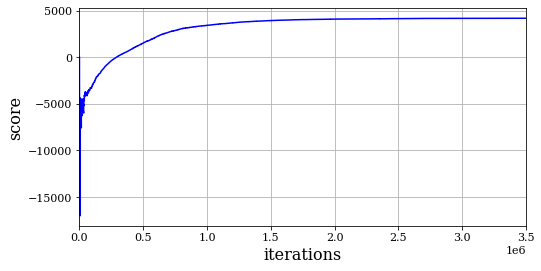

successful / failed paths:       2060 /          0


In [12]:
n_iter = 3500000
Q.train(target_state, n_iter)
plot_scores(Q.scores)
paths, _ =  Q.paths()

terrain2_path.png


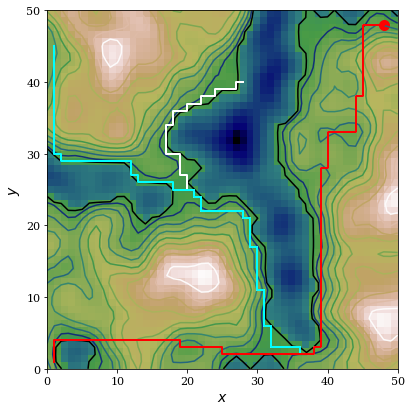

In [14]:
plot_selected_paths = True

if plot_selected_paths:
    paths = []
    pos = [(1,1), (1, 45), (28, 40)] 
    for start in pos:   
        paths.append(Q.get_path(start))
    
np.random.shuffle(paths)
plot_landscape(landscape, target=target_state, 
               paths=paths,
               filename='%s_path.png' % NAME)